In [2]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [16,9]
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from sklearn.metrics import roc_curve, auc

import theano
theano.config.compute_test_value = "ignore"

import pandas as pd
import numpy as np


Using TensorFlow backend.


In [3]:
def shuffle_in_unison(a, b):
    # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

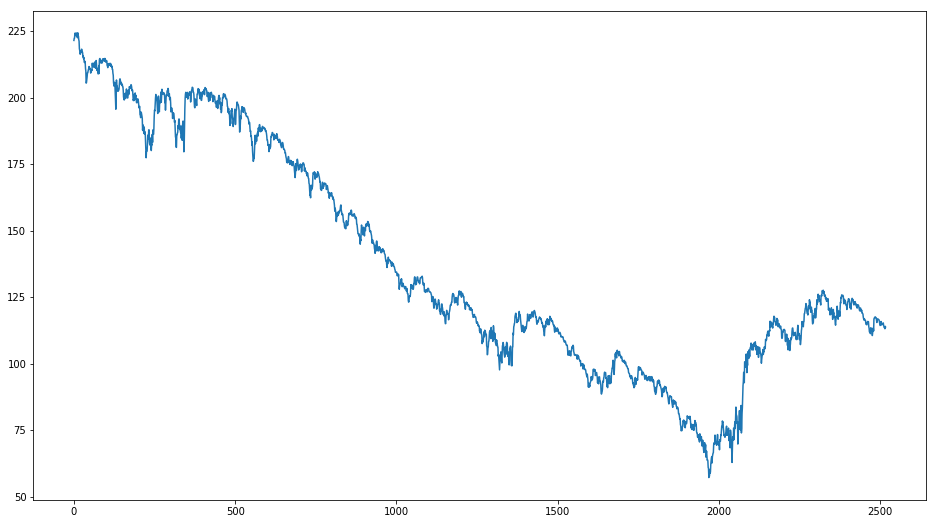

list index out of range


In [4]:
data = pd.read_csv('stockdatas/SPY.csv')[::-1]
data = data.loc[:, 'adjClose'].tolist()

# Uncomment below to use price instead time series
# data = data.loc[:, 'adjClose'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [18]:
print(X_test)

AttributeError: 'numpy.ndarray' object has no attribute 'tail'

In [5]:
# https://keras.io/optimizers/
# https://keras.io/activations/

model = Sequential()
model.add(Dense(64, input_dim=30,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = SGD(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
history = model.fit(X_train, Y_train, 
          epochs = 100, 
          batch_size = 10, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)



Train on 2234 samples, validate on 249 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 4.16614, saving model to test.hdf5
1s - loss: 6.5876 - acc: 0.5022 - val_loss: 4.1661 - val_acc: 0.5060
Epoch 2/100
Epoch 00001: val_loss improved from 4.16614 to 3.34452, saving model to test.hdf5
0s - loss: 4.8686 - acc: 0.5045 - val_loss: 3.3445 - val_acc: 0.5582
Epoch 3/100
Epoch 00002: val_loss improved from 3.34452 to 2.87487, saving model to test.hdf5
0s - loss: 4.0512 - acc: 0.5090 - val_loss: 2.8749 - val_acc: 0.5743
Epoch 4/100
Epoch 00003: val_loss improved from 2.87487 to 2.55556, saving model to test.hdf5
0s - loss: 3.5697 - acc: 0.5192 - val_loss: 2.5556 - val_acc: 0.5863
Epoch 5/100
Epoch 00004: val_loss improved from 2.55556 to 2.31587, saving model to test.hdf5
1s - loss: 3.2344 - acc: 0.5206 - val_loss: 2.3159 - val_acc: 0.5904
Epoch 6/100
Epoch 00005: val_loss improved from 2.31587 to 2.12597, saving model to test.hdf5
0s - loss: 2.9504 - acc: 0.5457 - val_loss: 2.12

Epoch 00050: val_loss improved from 0.92857 to 0.92105, saving model to test.hdf5
0s - loss: 1.0201 - acc: 0.5842 - val_loss: 0.9211 - val_acc: 0.5984
Epoch 52/100
Epoch 00051: val_loss improved from 0.92105 to 0.91651, saving model to test.hdf5
0s - loss: 1.0128 - acc: 0.5792 - val_loss: 0.9165 - val_acc: 0.5944
Epoch 53/100
Epoch 00052: val_loss improved from 0.91651 to 0.91170, saving model to test.hdf5
0s - loss: 1.0050 - acc: 0.5833 - val_loss: 0.9117 - val_acc: 0.5904
Epoch 54/100
Epoch 00053: val_loss improved from 0.91170 to 0.91149, saving model to test.hdf5
0s - loss: 1.0009 - acc: 0.5868 - val_loss: 0.9115 - val_acc: 0.5944
Epoch 55/100
Epoch 00054: val_loss improved from 0.91149 to 0.90935, saving model to test.hdf5
0s - loss: 0.9948 - acc: 0.5761 - val_loss: 0.9094 - val_acc: 0.5944
Epoch 56/100
Epoch 00055: val_loss improved from 0.90935 to 0.90377, saving model to test.hdf5
0s - loss: 0.9867 - acc: 0.5886 - val_loss: 0.9038 - val_acc: 0.5944
Epoch 57/100
Epoch 00056: val

In [7]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("\nModel Accuracy: %.2f%%" % (scores[1]*100))

 32/249 [==>...........................] - ETA: 0s
Model Accuracy: 59.44%


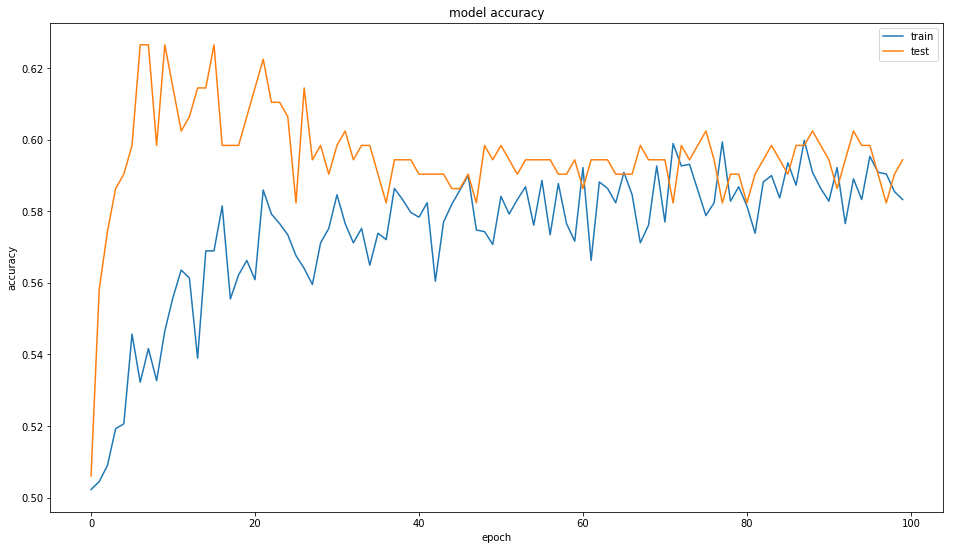

In [8]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predicting on test data
Generating results


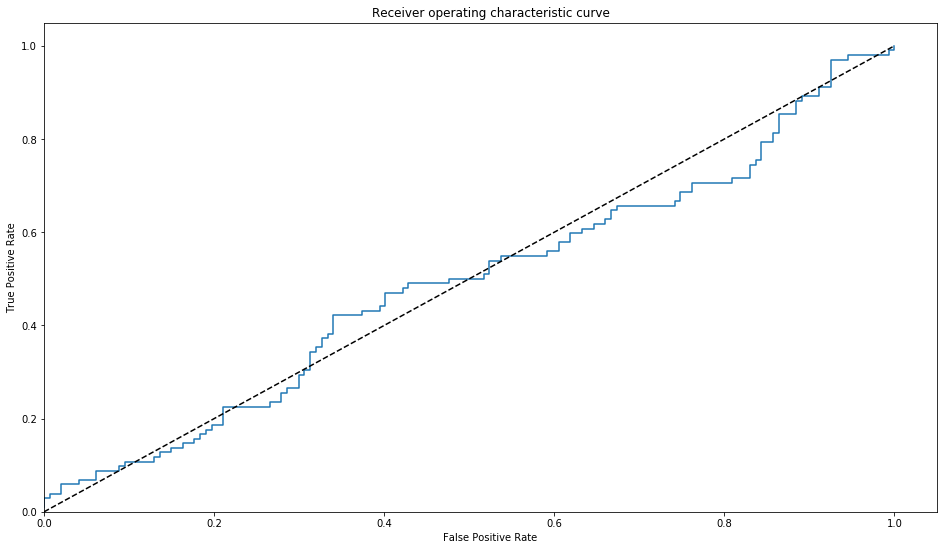

AUC: 0.490129


In [10]:
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)
    
print('Predicting on test data')
y_score = model.predict(X_test)

print('Generating results')
generate_results(Y_test[:, 0], y_score[:, 0])